In [1]:
from treasury_ml_utils.snowflake_utils import SnowflakeConnector

snowflake_client = SnowflakeConnector("joshua.choy@transferwise.com")

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://transferwise.okta-emea.com/app/snowflake/exk4istpb5gZUyV8u0i7/sso/saml?SAMLRequest=nZJbb%2BIwEIX%2FSuR9TuyEUFgLqLioAqm7RSFU2r6ZZEgtEjv1OA38%2BzpcVt2H9mHfIufMfGfmzOj%2BWJXeOxiUWo1JGDDigcp0LlUxJtv0wR8SD61QuSi1gjE5AZL7yQhFVdZ82thXlcBbA2g910gh736MSWMU1wIlciUqQG4zvpn%2BeuRRwLhABGMdjlxLcpSO9WptzSlt2zZoe4E2BY0YY5T9pE7VSX6QT4j6e0ZttNWZLm8lRzfTF4iQsrhDOIUjrK%2BFM6kuK%2FiOsruIkC%2FTdO2vnzYp8aa36eZaYVOB2YB5lxlsk8eLAXQOkjQaxNEwgMbPQFkjSj8MUOl2X4oDZLqqG%2BsaB%2B6L7iGnpS6kW9dqMSb1Qea7ZZHMYAXHhBX2LWnMbhfWsxzbdCmfbNTMD%2FP%2B%2Bs9cxuEqI97zLdyoC3eF2MBKdZFa98SiO5%2BFfhSlbMDDmMe9oHfXfyHewkUqlbDnyptv51ThHkwrEQJ9sMKHCsTZpqhr%2BncCCsdDLNHWu37xsj09DxsmBxRR0y47cjkffrZiJv%2BxlBH93OB6jL9dPqvFWpcyO3kP2lTCfh1fGITnF5n7%2B7OUQyVkOc1zA4guxrLU7dyAsO7mrWmA0MmF%2Bu%2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [21]:
df = snowflake_client.fetch(f"""
    SELECT *, ((BID_OUTRIGHT+OFFER_OUTRIGHT)/2) as mid
    FROM RPT_TREASURY.INT_ASSET_PRICING__FX_QUOTE_SNAPSHOT_HOURLY
    WHERE CCY_PAIR IN ('EURUSD', 'GBPUSD', 'USDJPY', 'EURGBP', 
                            'USDCNH', 'USDSGD',
                            'USDMYR', 'USDIDR', 'USDINR', 
                            'USDPHP', 'USDTWD', 'USDTHB',
                            'USDKRW')
    AND TENOR_CODE = 'SP'
    AND INSTRUMENT_TYPE = 'FXSpot'
    AND PROVIDER = 'BLOOMBERG'
    AND TIMESTAMP BETWEEN '2025-06-01 00:00:00' AND '2026-01-20 23:59:59'  
""")
ccy_df = df.pivot(index='timestamp', columns='ccy_pair', values='mid')
ccy_df.head()

ccy_pair,EURUSD,GBPUSD,USDCNH,USDIDR,USDINR,USDJPY,USDKRW,USDMYR,USDPHP,USDSGD,USDTHB,USDTWD
timestamp,,,,,,,,,,,,
2025-06-01 00:00:00,1.13475,1.3459,7.2051,16290.0,85.58125,144.025,1382.6,4.25675,55.7725,1.291,32.83,29.9145
2025-06-01 01:00:00,1.13475,1.3459,7.2051,16290.0,85.58125,144.025,1382.6,4.25675,55.7725,1.291,32.83,29.9145
2025-06-01 02:00:00,1.13475,1.3459,7.2051,16290.0,85.58125,144.025,1382.6,4.25675,55.7725,1.291,32.83,29.9145
2025-06-01 03:00:00,1.13475,1.3459,7.2051,16290.0,85.58125,144.025,1382.6,4.25675,55.7725,1.291,32.83,29.9145
2025-06-01 04:00:00,1.13475,1.3459,7.2051,16290.0,85.58125,144.025,1382.6,4.25675,55.7725,1.291,32.83,29.9145


In [11]:
ccy_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5497 entries, 2025-06-01 00:00:00 to 2026-01-20 23:00:00
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EURUSD  5497 non-null   float64
 1   GBPUSD  5497 non-null   float64
 2   USDCNH  5497 non-null   float64
 3   USDIDR  5497 non-null   float64
 4   USDINR  5497 non-null   float64
 5   USDJPY  5497 non-null   float64
 6   USDKRW  5497 non-null   float64
 7   USDMYR  5497 non-null   float64
 8   USDPHP  5497 non-null   float64
 9   USDSGD  5497 non-null   float64
 10  USDTHB  5497 non-null   float64
 11  USDTWD  5497 non-null   float64
dtypes: float64(12)
memory usage: 558.3 KB


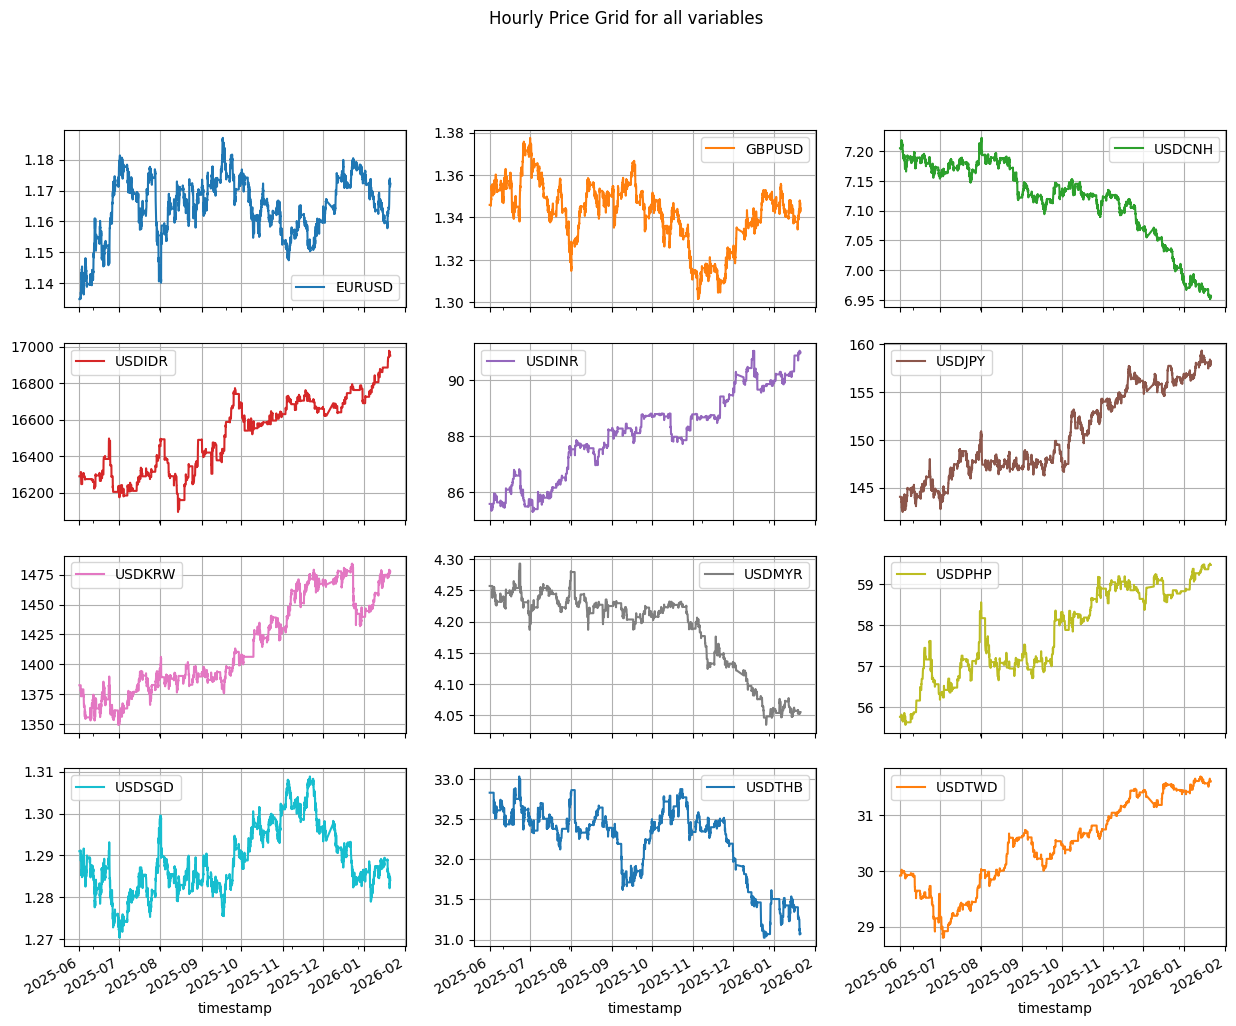

In [19]:
ccy_df.plot(subplots = True, layout = (4,3), figsize = (15,12), title = 'Hourly Price Grid for all variables', grid = True, sharex = True)
plt.show()

In [22]:
# compute log returns

log_returns = np.log(ccy_df / ccy_df.shift(1))
log_returns = log_returns.dropna()
log_returns.describe()

ccy_pair,EURUSD,GBPUSD,USDCNH,USDIDR,USDINR,USDJPY,USDKRW,USDMYR,USDPHP,USDSGD,USDTHB,USDTWD
count,5496.000000,5.496000e+03,5496.000000,5496.000000,5496.000000,5496.000000,5496.000000,5496.000000,5496.000000,5.496000e+03,5496.000000,5496.000000
mean,0.000006,-2.164306e-07,-0.000006,0.000007,0.000011,0.000017,0.000012,-0.000009,0.000012,-9.750779e-07,-0.000010,0.000010
std,0.000685,7.120131e-04,0.000237,0.000448,0.000413,0.000852,0.000900,0.000427,0.000559,4.163364e-04,0.000674,0.000531
min,-0.005130,-9.467482e-03,-0.003377,-0.006542,-0.010130,-0.012569,-0.013869,-0.008194,-0.010995,-7.302264e-03,-0.012170,-0.011336
25%,-0.000214,-2.229447e-04,-0.000080,0.000000,0.000000,-0.000255,0.000000,0.000000,0.000000,-1.548707e-04,0.000000,0.000000
50%,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,0.000215,2.233888e-04,0.000070,0.000000,0.000000,0.000318,0.000034,0.000000,0.000000,1.543091e-04,0.000000,0.000000
max,0.012288,9.605277e-03,0.001975,0.008307,0.007451,0.013338,0.010187,0.005217,0.007983,2.932780e-03,0.009208,0.012071


# PCA

In [26]:
# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

macro_rets = log_returns[['GBPUSD' ,'EURUSD', 'USDJPY']]


# scaling data 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(macro_rets.dropna())
pca = PCA(n_components=3).fit(scaled_data)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance:", pca.explained_variance_ratio_.sum())

Explained variance ratio: [0.7669209  0.15446192 0.07861719]
Cumulative explained variance: 1.0


               PC1       PC2       PC3
ccy_pair                              
GBPUSD    0.585939  0.492606 -0.643440
EURUSD    0.601828  0.267192  0.752603
USDJPY   -0.542659  0.828220  0.139906


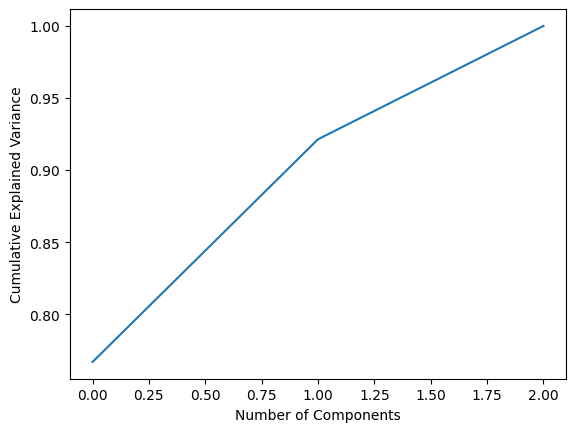

In [27]:
# check loadings contribution

loadings = pd.DataFrame(
    pca.components_.T,
    index=macro_rets.columns,
    columns=[f"PC{i+1}" for i in range(pca.n_components)]
)
print(loadings)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.show()

# Regression

In [28]:
pca_factors = pd.DataFrame(pca.transform(scaled_data), 
                           index=macro_rets.dropna().index, # Use the index from the data fed into PCA
                           columns=[f"PC{i+1}" for i in range(pca.n_components)])

pca_factors.head()

,PC1,PC2,PC3
timestamp,,,
2025-06-01 01:00:00,0.005842,-0.018738,-0.009498
2025-06-01 02:00:00,0.005842,-0.018738,-0.009498
2025-06-01 03:00:00,0.005842,-0.018738,-0.009498
2025-06-01 04:00:00,0.005842,-0.018738,-0.009498
2025-06-01 05:00:00,0.005842,-0.018738,-0.009498


In [29]:
log_returns.keys()

Index(['EURUSD', 'GBPUSD', 'USDCNH', 'USDIDR', 'USDINR', 'USDJPY', 'USDKRW',
       'USDMYR', 'USDPHP', 'USDSGD', 'USDTHB', 'USDTWD'],
      dtype='object', name='ccy_pair')

In [30]:
fx_returns = log_returns[['USDCNH', 'USDSGD', 'USDTHB',
                          'USDPHP', 'USDIDR', 'USDINR',
                          'USDKRW', 'USDTWD']]
fx_returns.head()

ccy_pair,USDCNH,USDSGD,USDTHB,USDPHP,USDIDR,USDINR,USDKRW,USDTWD
timestamp,,,,,,,,
2025-06-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-06-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-06-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-06-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-06-01 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
# rolling window approach

window_pca = 30*24    # 3 month PCA window
window_reg = 30*24    # 60-day regression window
n_components = 3

pca_betas = []

for end_idx in range(window_pca + window_reg, len(macro_rets)):
    start_idx = end_idx - window_pca
    pca = PCA(n_components=n_components)
    scaled_data = scaler.fit_transform(macro_rets.iloc[start_idx:end_idx])
    pca.fit(scaled_data)
    
    pc_scores = pd.DataFrame(
        pca.transform(scaled_data),
        index=macro_rets.iloc[start_idx:end_idx].index,
        columns=[f'PC{i+1}' for i in range(n_components)]
    )
    
    # now regress FX on these PCs for the most recent 60 days
    fx_window = fx_returns.iloc[end_idx-window_reg:end_idx]
    
    for ccy in fx_window.columns:
        model = sm.OLS(fx_window[ccy], sm.add_constant(pc_scores.iloc[-window_reg:], )).fit(cov_type="HC3")
        pca_betas.append({
            'date': fx_window.index[-1],
            'ccy': ccy,
            **{f'PC{i+1}': model.params[i+1] for i in range(n_components)},
            'R2': model.rsquared
        })

In [33]:
pca_beta_df = pd.DataFrame(pca_betas)
pca_beta_df.iloc[-15:]

,date,ccy,PC1,PC2,PC3,R2
32433,2026-01-20 21:00:00,USDSGD,-0.000162,0.000007,-0.000087,0.469089
32434,2026-01-20 21:00:00,USDTHB,-0.000041,0.000050,0.000045,0.015716
32435,2026-01-20 21:00:00,USDPHP,-0.000009,0.000031,0.000014,0.011499
32436,2026-01-20 21:00:00,USDIDR,-0.000017,0.000026,0.000003,0.010414
32437,2026-01-20 21:00:00,USDINR,-0.000002,-0.000012,-0.000005,0.001053
32438,2026-01-20 21:00:00,USDKRW,-0.000174,0.000202,-0.000142,0.094970
32439,2026-01-20 21:00:00,USDTWD,-0.000017,0.000007,0.000014,0.005418
32440,2026-01-20 22:00:00,USDCNH,-0.000056,0.000016,-0.000028,0.131516
32441,2026-01-20 22:00:00,USDSGD,-0.000162,0.000007,-0.000087,0.469299
32442,2026-01-20 22:00:00,USDTHB,-0.000041,0.000050,0.000045,0.015738


In [34]:
loadings = pd.DataFrame(pca.components_.T, index=macro_rets.columns, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

In [35]:
scaler = StandardScaler().fit(macro_rets.dropna())
scaler

,copy,True
,with_mean,True
,with_std,True


In [36]:
# --- Step 1: pick the latest snapshot per currency ---
latest_date = pca_beta_df['date'].max()
snapshot = (
    pca_beta_df[pca_beta_df['date'] == latest_date]
    .set_index('ccy')
    [['PC1','PC2','PC3','R2']]
)

# --- Step 2: align with loadings ---
pc_cols = [c for c in snapshot.columns if c.startswith('PC')]
W = loadings[pc_cols]   # rows = original variables, cols = PCs

# --- Step 3: map FX→PC betas to standardized original drivers ---
beta_stdX = snapshot[pc_cols].dot(W.T)

# --- Step 4: undo standardization (back to real-world units) ---
driver_scales = pd.Series(scaler.scale_, index=W.index)
fx_to_orig = beta_stdX.div(driver_scales, axis=1)

# --- Step 5: convert to bps per 1% driver move ---
fx_to_orig_bps_per_1pct = fx_to_orig * 100

# --- Step 6: add metadata and pretty print ---
fx_to_orig_bps_per_1pct['R2'] = snapshot['R2']
fx_to_orig_bps_per_1pct['Date'] = latest_date
fx_to_orig_bps_per_1pct = fx_to_orig_bps_per_1pct.sort_values('R2', ascending = False)
fx_to_orig_bps_per_1pct.round(5)

ccy_pair,GBPUSD,EURUSD,USDJPY,R2,Date
ccy,,,,,
USDSGD,-4.70127,-23.01419,10.43464,0.46930,2026-01-20 22:00:00
USDCNH,-1.14244,-7.04066,4.97064,0.13152,2026-01-20 22:00:00
USDKRW,10.64771,-19.81793,30.44634,0.09491,2026-01-20 22:00:00
USDTHB,-5.01397,3.71020,7.64208,0.01574,2026-01-20 22:00:00
USDPHP,-0.37028,2.23907,3.70952,0.01150,2026-01-20 22:00:00
USDIDR,-0.20034,0.16158,3.62930,0.01041,2026-01-20 22:00:00
USDTWD,-2.47085,0.32369,1.81599,0.00542,2026-01-20 22:00:00
USDINR,-0.30524,-1.30637,-1.14354,0.00106,2026-01-20 22:00:00
